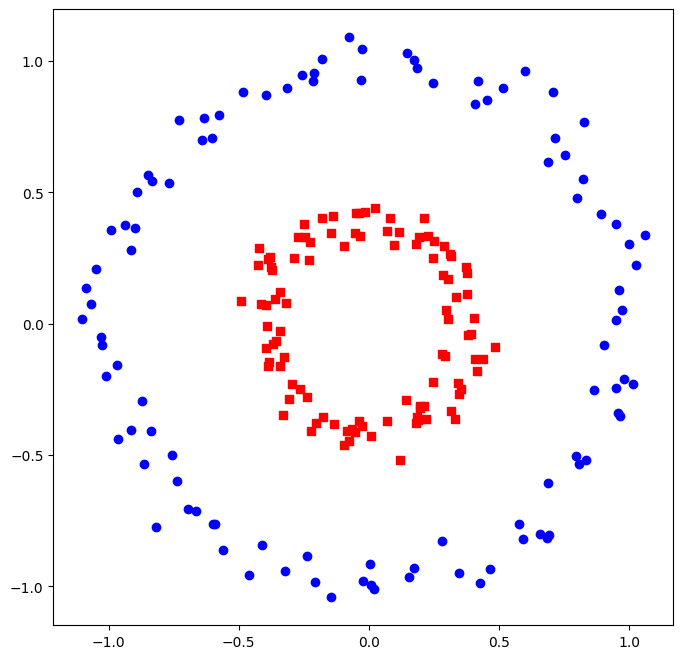

In [11]:
import numpy as np
from sklearn.datasets import make_circles

X, Y = make_circles(n_samples=200,
             noise=0.05,
             factor=0.4)
A = X[np.where(Y == 0)]
B = X[np.where(Y == 1)]

from matplotlib import pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(A[:, 0], A[:, 1], marker='o', color='blue')
plt.scatter(B[:, 0], B[:, 1], marker='s', color='red')

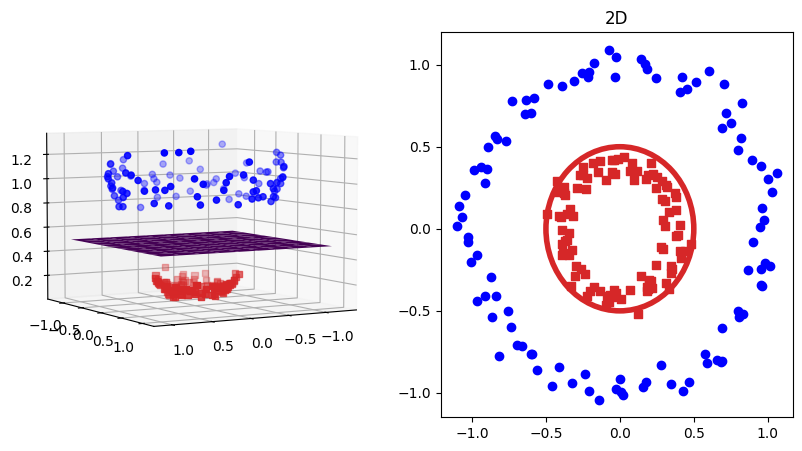

In [53]:
def transform_function(x,y):
    return [x,y,x**2.0+y**2.0]
A1 = np.array([transform_function(x,y) for x, y in zip(A[:,0], A[:,1])])
B1 = np.array([transform_function(x,y) for x, y in zip(B[:,0], B[:,1])])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(A1[:, 0], A1[:, 1], A1[:, 2], marker='o', color='blue')
ax.scatter(B1[:, 0], B1[:, 1], B1[:, 2], marker='s', c='C3')
ax.view_init(5, 60)

x = np.arange(-1.25, 1.25, 0.25)
y = np.arange(-1.25, 1.25, 0.25)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z[:,:] = 0.5
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis')

ax2d = fig.add_subplot(122)
ax2d.set_title("2D")
ax2d.scatter(A1[:, 0], A1[:, 1], marker='o', color='blue')
ax2d.scatter(B1[:, 0], B1[:, 1], marker='s', color='C3')
ax2d.add_patch(plt.Circle((0, 0), 0.5, color='C3',fill=False, linewidth=4.0))
plt.show()

In [54]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 12345

from qiskit_machine_learning.datasets import ad_hoc_data
train_data, train_labels, test_data, test_labels, sample_total = (
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3,
                include_sample_total=True, one_hot=False))

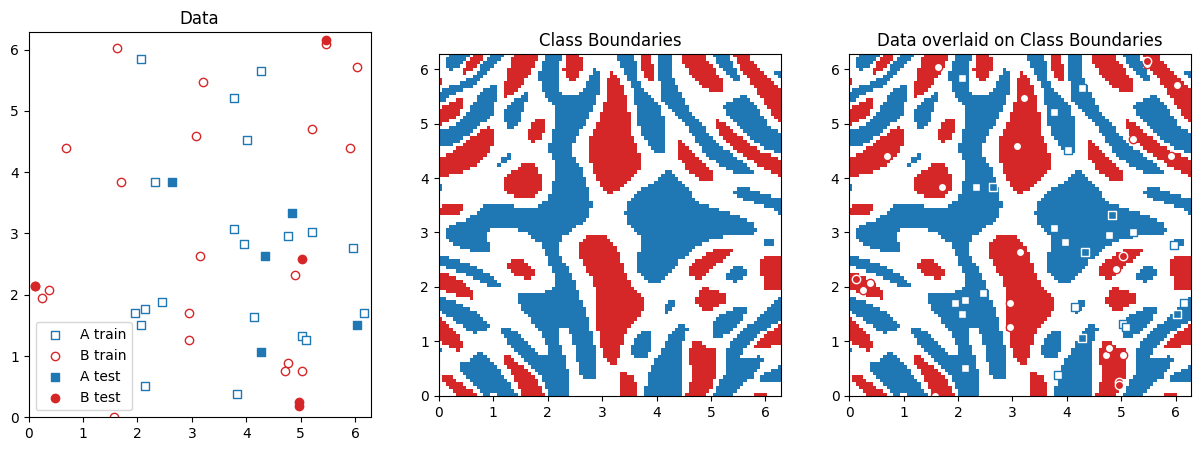

In [55]:
fig = plt.figure(figsize=(15, 5))
axdata = fig.add_subplot(131)
axdata.set_title("Data")
axdata.set_ylim(0, 2 * np.pi)
axdata.set_xlim(0, 2 * np.pi)
plt.scatter(train_data[np.where(train_labels[:] == 0), 0],
            train_data[np.where(train_labels[:] == 0), 1],
            marker='s', facecolors='w', edgecolors='C0',
            label="A train")
plt.scatter(train_data[np.where(train_labels[:] == 1), 0],
            train_data[np.where(train_labels[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='C3',
            label="B train")
plt.scatter(test_data[np.where(test_labels[:] == 0), 0],
            test_data[np.where(test_labels[:] == 0), 1],
            marker='s', facecolors='C0', label="A test")
plt.scatter(test_data[np.where(test_labels[:] == 1), 0],
            test_data[np.where(test_labels[:] == 1), 1],
            marker='o', facecolors='C3', label="B test")
plt.legend()

from matplotlib.colors import ListedColormap
cmap = ListedColormap(["C3","w","C0"])
axmap = fig.add_subplot(132)
axmap.set_title("Class Boundaries")
axmap.set_ylim(0, 2 * np.pi)
axmap.set_xlim(0, 2 * np.pi)
axmap.imshow(np.asmatrix(sample_total).T,
             interpolation='nearest',
             origin='lower', cmap=cmap,
             extent=[0, 2 * np.pi, 0, 2 * np.pi])
axboth = fig.add_subplot(133)
axboth.set_title("Data overlaid on Class Boundaries")
axboth.set_ylim(0, 2 * np.pi)
axboth.set_xlim(0, 2 * np.pi)
axboth.imshow(np.asmatrix(sample_total).T, interpolation='nearest',
              origin='lower', cmap=cmap,
              extent=[0, 2 * np.pi, 0, 2 * np.pi])
axboth.scatter(train_data[np.where(train_labels[:] == 0), 0],
               train_data[np.where(train_labels[:] == 0), 1],
               marker='s', facecolors='w', edgecolors='C0', label="A")
axboth.scatter(train_data[np.where(train_labels[:] == 1), 0],
               train_data[np.where(train_labels[:] == 1), 1],
               marker='o', facecolors='w', edgecolors='C3', label="B")
axboth.scatter(test_data[np.where(test_labels[:] == 0), 0],
               test_data[np.where(test_labels[:] == 0), 1],
               marker='s', facecolors='C0', edgecolors='w',
               label="A test")
axboth.scatter(test_data[np.where(test_labels[:] == 1), 0],
               test_data[np.where(test_labels[:] == 1), 1],
               marker='o', facecolors='C3', edgecolors='w',
               label="B test")
plt.show()

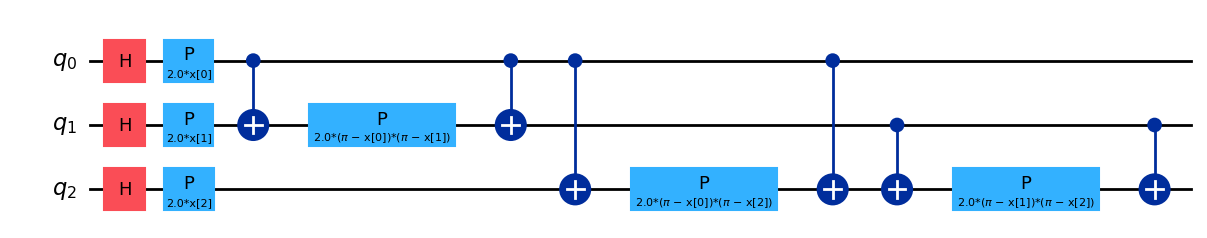

In [56]:
from qiskit.circuit.library import ZZFeatureMap
# 3 features, depth 1
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.decompose().draw()

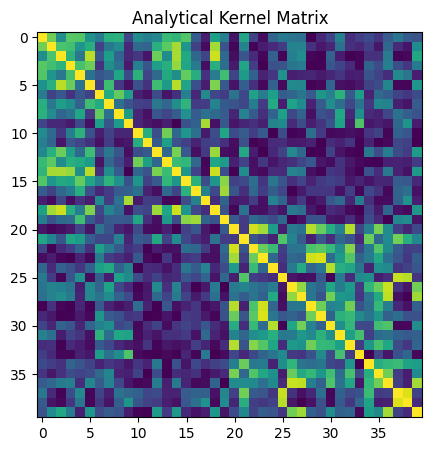

In [125]:
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector, state_fidelity
def calculate_kernel(feature_map, x_data, y_data=None):
    if y_data is None:
        y_data = x_data
    
    x_circuits = [feature_map.assign_parameters(x) for x in x_data]
    y_circuits = [feature_map.assign_parameters(y) for y in y_data]

    kernel = np.zeros((y_data.shape[0], x_data.shape[0]))
    
    for i, x_c in enumerate(x_circuits):
        for j, y_c in enumerate(y_circuits):
            sv_x = Statevector.from_instruction(x_c)
            sv_y = Statevector.from_instruction(y_c)
            fidelity = state_fidelity(sv_x, sv_y)
            
            kernel[j, i] = np.abs(fidelity)
            
    return kernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
kernel = calculate_kernel(adhoc_feature_map, train_data)
plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(kernel),interpolation='nearest', origin='upper')
plt.title("Analytical Kernel Matrix")
plt.show()

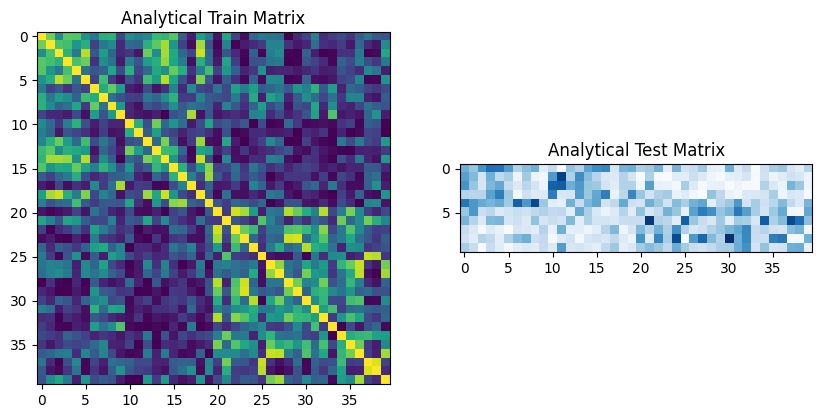

In [126]:
train_kernel = calculate_kernel(adhoc_feature_map, train_data)
test_kernel = calculate_kernel(adhoc_feature_map, train_data, test_data)
# plot analytical matrices
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(np.asmatrix(train_kernel), interpolation='nearest',
              origin='upper')
axs[0].set_title("Analytical Train Matrix")
axs[1].imshow(np.asmatrix(test_kernel), interpolation='nearest',
              origin='upper', cmap='Blues')
axs[1].set_title("Analytical Test Matrix")
plt.show()

In [129]:
from sklearn.svm import SVC
# train scikit-learn svm model
model = SVC(kernel='precomputed')
model.fit(train_kernel, train_labels)
print("Number of support vectors for each class:",model.n_support_)
print("Indices of support vectors:", model.support_)

Number of support vectors for each class: [ 9 10]
Indices of support vectors: [ 3  6  7  8  9 11 12 17 19 21 22 24 25 26 27 31 33 38 39]


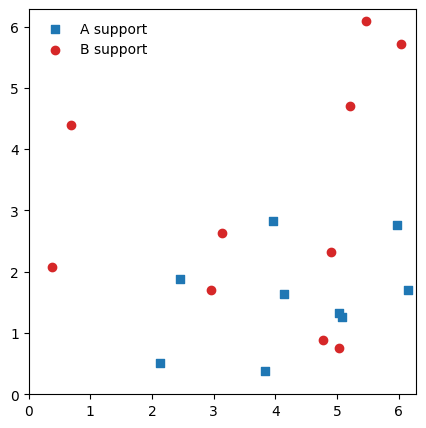

In [130]:
# Plot support vectors
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.scatter(train_data[model.support_[0:model.n_support_[0]], 0],
            train_data[model.support_[0:model.n_support_[0]], 1],
            marker='s', label="A support")
plt.scatter(train_data[model.support_[model.n_support_[0]:], 0],
            train_data[model.support_[model.n_support_[0]:], 1],
            marker='o', c='C3', label="B support")
plt.legend(loc='upper left', frameon=False)
plt.show()

In [131]:
model.score(test_kernel, test_labels)

1.0

IndentationError: unexpected indent (2850840185.py, line 2)